In [68]:
# HIDE_CELL
from IPython.display import Latex
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, auc

def Tex(v):
    return Latex(f"{v}")
def MathTex(v):
    return Latex(f"${v}$") 
def DMathTex(v):
    return Latex(f"$$\n{v}\n$$")

# These are slow but I'm ok with it for this post.
def roc_curve(scores, labels, thresholds):
    assert scores.shape == labels.shape
    recalls = []
    fprs = []
    for threshold in thresholds:
        idxs = np.arange(scores.shape[0])[scores >= threshold]
        recall = labels[idxs].sum() / labels.sum()
        fpr = (1 - labels[idxs]).sum() / (1 - labels).sum()
        recalls.append(recall)
        fprs.append(fpr)
    return recalls, fprs, auc(fprs, recalls)
        

def pr_curve(scores, labels, thresholds):
    assert scores.shape == labels.shape
    recalls = []
    precisions = []
    for threshold in thresholds:
        idxs = np.arange(scores.shape[0])[scores >= threshold]
        recall = labels[idxs].sum() / labels.sum()
        if idxs.shape[0] > 0:
            precision = labels[idxs].sum() / idxs.shape[0]
        else:
            precision = np.nan
        recalls.append(recall)
        precisions.append(precision)
    return precisions, recalls, auc(recalls, precisions)

def draw_curve(xs, ys, title=None, xlabel=None, ylabel=None, style='line', show=True):
    if style == 'line':
        plt.plot(xs, ys)
    elif style == 'scatter':
        plt.scatter(xs, ys)
    else:
        raise ValueError(f"Invalid style '{style}'")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if show:
        plt.show()

I was just thinking about ROC AUC and PR AUC. Both are binary classification metrics, but ROC AUC can suffer in the presence of severe class imbalance. Here’s a way to see how PR AUC might do better.

By the end of this post we'll see why ROC AUC can give you great results even for a bad model in the presence of class imbalance, and how PR AUC's focus on the positive class helps avoid this pitfall.

## ROC AUC Basics

We'll start by examining ROC AUC. Feel free to skip this section if you are already familiar. The ROC curve depends on 2 things:
* **True positive rate (aka recall) (Y axis):** Among all the positives, what fraction did the model say were positive?

$$ \frac{\text{num positives classified positive}}{\text{total num positive}} $$

* **False positive rate (X axis):** Among all the negatives, what fraction did the model say were positive?

$$
\frac{\text{num negatives classified positive}}{\text{total num negative}}
$$

Here's an example of a typical ROC curve:

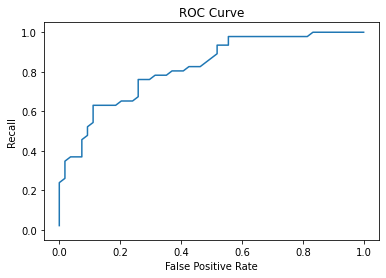

In [69]:
# HIDE_INPUT
np.random.seed(5)
scores = np.linspace(0, 1.0, 100)
labels = np.random.random(scores.shape) <= scores
ys, xs, area = roc_curve(scores, labels, np.linspace(0.0, 1.0, 50))
draw_curve(xs, ys, title="ROC Curve", xlabel="False Positive Rate", ylabel="Recall", style='line')

scores_orig, labels_orig = scores, labels

Each point on the line corresponds to a particular model score threshold, whereby all examples above the threshold are classified as positive and all the examples below are classified as negative. We then compute the **recall** and **false positive rate** given that threshold to get a point. The above chart was created from 50 different thresholds between 0 and 1, as you can see here:

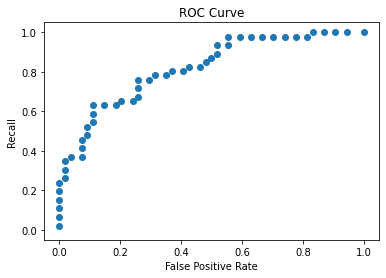

In [70]:
# HIDE_INPUT
draw_curve(xs, ys, title="ROC Curve", xlabel="False Positive Rate", ylabel="Recall", style='scatter')

The area underneath this curve is called the ROC AUC, and it is a common way of measuring model performance. A value of 1 is perfect and 0 is awful. In the above diagram, the area is **{{round(area, 2)}}**.

### Understanding the curve
It turns out that the bottom leftmost point corresponds to a threshold of 1. At this threshold, recall is 0 because no positive examples have scores above the threshold, and the false positive rate is also 0 since no negatives were classified as positive. 

As we decrease the threshold and allow more examples to be classified as positive, depending on whether they have positive or negative labels, recall or the false positive rate will increase. If we decrease our threshold and more positive examples are correctly classified as positive, recall will go up. Conversely, if we decrease our threshold and more negative examples are misclassified as positive, the false positive rate will go up. Overall this moves us up and to the right along the curve (recall or false positive rate is always increasing as we lower the threshold), resulting in the shape we see above.

### Concrete Example: Perfect and Worst Case Models
Suppose you have a model that scores 100 positives above 1000 negatives with the following scores:
* 100 positive examples with scores over 0.80
* 1000 negative examples with scores below 0.80

This is a perfect model as far as ordering is concerned, so let’s see if the ROC AUC is 1.

To see this, we’ll start with a super high threshold of **1**, and slowly decrease it. As we decrease it, more and more instances will be labeled as positive by the model, and we can observe what happens to the ROC AUC curve.

As we decrease the threshold, we start including more and more of those 100 positives. The recall slowly climbs from 0 to 1. Throughout this process, we aren’t classifying any negatives as positive. So the false positive rate stays at 0, and all these points on the curve have x coordinate 0.

Once our threshold hits 0.80, we’ve included all the positives, and our recall reaches 1. As we lower the threshold further, we start to include some negatives. The false positive rate starts to increase. But for all these different false positive rates, the recall is still 1. So as we move along the x axis, the y coordinate is always 1. In the end, we end up with a horizontal line from (0,1) to (1,1). The area under this is 1, so the ROC AUC is 1. We can see this below:

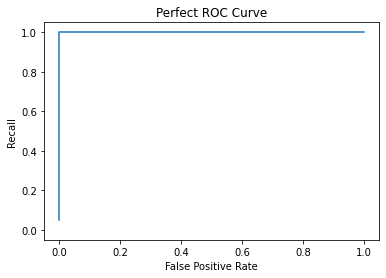

In [71]:
# HIDE_INPUT
perf_ys, perf_xs, _ = roc_curve(scores, scores > 0.80, np.linspace(0.0, 1.0, 100))
draw_curve(
    perf_xs,
    perf_ys,
    title="Perfect ROC Curve",
    xlabel="False Positive Rate", 
    ylabel="Recall",
    style='line')

Similarly, consider a terrible model that scores the 1000 negative examples above the 100 positive ones:
* 1000 negative examples with scores over 0.80
* 100 positive examples with scores below 0.80

Its ROC AUC curve would look like this:

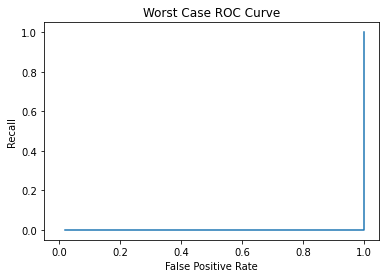

In [72]:
# HIDE_INPUT
bad_ys, bad_xs, _ = roc_curve(scores, scores < 0.50, np.linspace(0.0, 1.0, 100))
draw_curve(
    bad_xs,
    bad_ys,
    title="Worst Case ROC Curve",
    xlabel="False Positive Rate", 
    ylabel="Recall",
    style='line')

We again start with a high threshold of **1** and slowly decrease it. As we decrease the threshold, we start misclassifying those 1000 negatives as positive, which increases the false positive rate. During this time we aren't correctly classifying any of the 100 positives yet, so all these points have y coordinate (recall) 0. By the time our threshold reaches 0.80, we have classified all 1000 negatives as positive. This means our false positive rate is 1. Dropping the threshold further starts to include more positives and recall goes up, but we don't get any area from it since it's a vertcal line from (1, 0) to (1, 1).

Thus the ROC AUC is 0.

## Introducing Class Imbalance
Now that we understand ROC AUC, what happens to this metric when class imbalance is introduced? What if there are a lot more negatives than positives in our data?

We'll start with a balanced case. Suppose our model scores examples as follows:
* 100 positives with scores above 0.90
* 350 negatives with scores between 0.90 and 0.80
* 200 positives with scores between 0.50 and 0.80
* 250 more negatives with scores below 0.50

This model could be better. It's scoring those 350 negatives a bit high.

If we do the same threshold lowering experiment, we’ll first include these 100 positives as our threshold lowers to 0.90. At this point recall will be $\frac{100}{300}$ and the false positive rate will be 0. Continuing on, we'll include those 350 negatives as our threshold lowers to 0.80. This whole time we’ll be moving along the X axis as our false positive rate increases, but the recall will remain the same. By the time the threshold reaches 0.80, the false positive rate is $\frac{350}{600}$.

Let's keep lowering the threshold from 0.80 to 0.50. As we do this we include the 200 positives. The false positive rate stays at $\frac{350}{600}$ but recall increases. Once we hit a threshold of 0.50 we have included all 300 positives, and recall reaches 1. As we further lower the threshold, the false positive rate starts to increase again since we’re including those last 250 negatives, but recall is 1 the whole time.

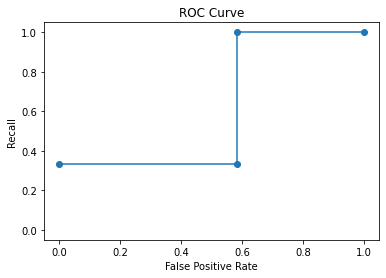

In [73]:
# HIDE_INPUT
scores = np.concatenate([np.ones(100), np.ones(350) * 0.80, np.ones(200) * 0.50, np.ones(250) * 0.10])
labels = np.concatenate([np.ones(100), np.zeros(350), np.ones(200), np.zeros(250)])
ys, xs, area = roc_curve(scores, labels, np.linspace(0.0, 1.0, 100))
draw_curve(
    xs,
    ys,
    title="ROC Curve",
    xlabel="False Positive Rate", 
    ylabel="Recall",
    style='line',
    show=False)
ys, xs, _ = roc_curve(scores, labels, [0.90, 0.80, 0.50, 0.0])
draw_curve(
    xs,
    ys,
    title="ROC Curve",
    xlabel="False Positive Rate", 
    ylabel="Recall",
    style='scatter',
    show=True)

The ROC AUC here is **{{round(area,2)}}**. So not great, as we would hope.

Now let's make it much more imbalanced. Suppose our model scores examples as follows:
* 100 positives with scores above 0.90
* 350 negatives with scores between 0.90 and 0.80
* 200 positives with scores between 0.50 and 0.80
* 10,650 more negatives with scores below 0.50

We'll do the same threshold decreasing experiment, starting from 1. When our threshold reaches 0.90, we've included those 100 positives as before, so recall is again $\frac{100}{300}$ and the false positive rate is 0. Once our threshold hits 0.80, recall is still the same and the false positive rate is $\frac{100}{11,000}$. Then we start including those 200 positives, and the recall shoots up to 1. Finally, we begin including the 10,900 negatives, which brings our false positive rate to 1.

Let's see what the curve looks like:

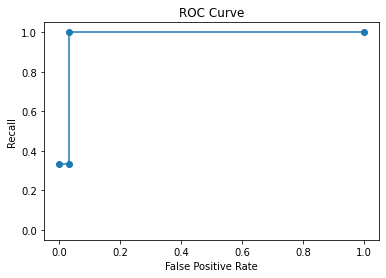

In [74]:
# HIDE_INPUT
scores = np.concatenate([np.ones(100), np.ones(350) * 0.80, np.ones(200) * 0.50, np.ones(10650) * 0.10])
labels = np.concatenate([np.ones(100), np.zeros(350), np.ones(200), np.zeros(10650)])
ys, xs, area = roc_curve(scores, labels, np.linspace(0.0, 1.0, 100))
draw_curve(
    xs,
    ys,
    title="ROC Curve",
    xlabel="False Positive Rate", 
    ylabel="Recall",
    style='line',
    show=False)
ys, xs, _ = roc_curve(scores, labels, [0.90, 0.80, 0.50, 0.0])
draw_curve(
    xs,
    ys,
    title="ROC Curve",
    xlabel="False Positive Rate", 
    ylabel="Recall",
    style='scatter',
    show=True)

The ROC AUC here is... **{{round(area, 2)}}**?!

That's a great score! But wait, isn't this model not good? Imagine if we used it in production and it behaved like this. Many of the examples with high scores in the 0.80 - 0.90 range are negatives, and most of the positives have scores below 0.80. So ROC AUC has deceived us here.

How can we address this situation? Enter PR AUC.

## PR AUC to the rescue
PR AUC is the area under the precision recall curve. Its axes are:
* **Precision (y-axis):** Of the instances that were classified as positive, what fraction are actually positive?

$$ \frac{\text{num classified positive and actually positive}}{\text{num classified positive}}$$

* **Recall (x-axis):** Of all the positive instances, what fraction did the model classify as positive?

$$ \frac{\text{num positives classified positive}}{\text{total num positive}}$$

A typical PR curve might look like this (it doesn't have to though):

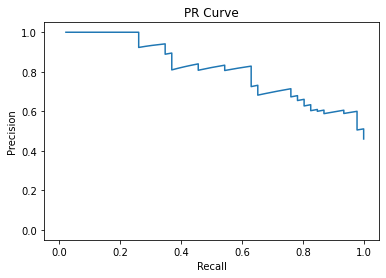

In [75]:
# HIDE_INPUT
ys, xs, area = pr_curve(scores_orig, labels_orig, np.linspace(0.0, 1.0, 500))
draw_curve(xs, ys, title="PR Curve", xlabel="Recall", ylabel="Precision", style='line')

(By the way, the PR AUC of that curve is **{{round(area, 2)}}**).

Let's revisit our class imbalance situation. Again suppose our model scores examples as follows:
* 100 positives with scores above 0.90
* 350 negatives with scores between 0.90 and 0.80
* 200 positives with scores between 0.50 and 0.80
* 250 more negatives with scores below 0.50

We will again start with a high threshold and decrease it. Once the threshold decreases to 0.90, those 100 positives are classified as positive, so precision is 1 and recall is $\frac{100}{300}$.

As our threshold decreases to 0.80 we classify those 350 negatives as positive. Recall remains the same, but precision drops to $\frac{100}{450}$.

Once the threshold goes down to 0.50, we'll have included those 200 positives. Recall will increase to 1, and precision will increase to $\frac{300}{650}$.

After dropping our threshold below 0.50, we will begin including the 250 negatives. Recall will remain at 1, but precision will slowly drop. After the first of those 250 negatives precision will be $\frac{300}{651}$, then $\frac{300}{652}$, etc. all the way to $\frac{300}{900}$ when our threshold reaches 0.

Here's the chart:

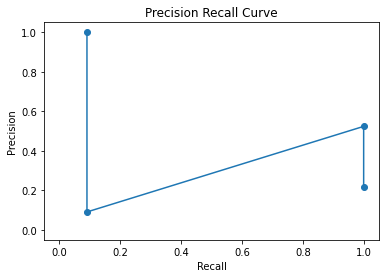

In [76]:
# HIDE_INPUT
scores = np.concatenate([np.ones(10), np.ones(100) * 0.80, np.ones(100) * 0.50, np.ones(300) * 0.10])
labels = np.concatenate([np.ones(10), np.zeros(100), np.ones(100), np.zeros(300)])
ys, xs, area = pr_curve(scores, labels, np.linspace(0.0, 1.0, 100))
draw_curve(
    xs,
    ys,
    title="Precision Recall Curve",
    xlabel="Recall", 
    ylabel="Precision",
    style='line',
    show=False)
ys, xs, _ = pr_curve(scores, labels, [0.90, 0.80, 0.50, 0.0])
draw_curve(
    xs,
    ys,
    title="Precision Recall Curve",
    xlabel="Recall", 
    ylabel="Precision",
    style='scatter',
    show=True)

The PR AUC here is a lowly **{{round(area, 2)}}**. Note that PR AUC has really penalized this model for misclassifying those 350 negatives as positive!

Now what if instead of 250 negatives at the end, we had 10,900 negatives like before? How would PR AUC change? Would it jump up like ROC AUC did?

If we look closely, these 250 negatives didn't really matter. Since recall was already at 1, we were just moving down the y axis on the chart as we included those 250 negatives and decreased precision.

**So it wouldn't matter if we had 250 negatives at the end, or 1 negative, or 10,000. The chart would look exactly the same, and the PR AUC would be exactly the same. As long as the positives are above a threshold, PR AUC doesn't care how many negatives are below.**

## Bottom Line

#### False Positive Rate vs. Precision
In ROC AUC, the problem metric was false positive rate. Adding a bunch of negatives (increasing the denominator by a lot) makes changes in the numerator a lot less impactful. This means that there's little difference between a model that misclassifies 10 of 10,000 negatives as positive and one that misclassifies 50 of 10,000. Both will have low false positive rates, which keeps the x-axis value on the ROC curve low.

If those 10,000 negatives all have low scores, then the false positive rate will only increase in earnest once the threshold is low enough for the model to misclassify the bulk of those 10,000 examples as positive, and by that time the model has probably already correctly classified most of the positives. Because of this, the recall will reach 1 while the false positive rate is still pretty low, which leads to a large area under the curve.

Precision, by contrast, doesn't care how many negatives there are. All it cares about is whether the examples that are classified as positive are actually positive. In fact, for the entire PR AUC chart, negatives only matter if they are misclassified as positive. Neither recall nor precision cares how many negatives the model correctly classifies as negative, as long as they all have lower scores than the positives.

#### Conclusion
So as we can see, ROC AUC and PR AUC measure different things:
* PR AUC focuses almost entirely on the positive class, only considering negatives insofar as they interfere with positive classifications. The model doesn't get any brownie points for correctly classifying a huge set of negatives correctly as long as the positives are taken care of. In our imbalanced example, the model did a poor job by misclassifying those 350 negatives, so PR AUC gave it a heavy penalty.
* ROC AUC considers both classes, and will give a model brownie points for correctly classifying lots of negatives and positives. In our imbalanced example, adding lots of negative examples with low scores caused ROC AUC to give the model lots of brownie points for these correct classifications, overlooking those 350 misclassified negatives.

Depending on the situation, it's probably worth adding both to your metric suite!

